# Feature Engineering

#### MDS Quality Measures Dataset 
- [Import Necessary Modules and Dataset](#import)

#### Provider Information Dataset
- [Import Dataset and Quick Assessment](#import1)
- [Training, Validation, and Testing Split](#split)
- [Standardize Features](#standardize)
- [Featuring Selection](#feature)
- [Data Leakage Investigation](#leakage)

## MDS Quality Measures Dataset 

### Import Necessary Modules and Dataset <a id = 'import'></a>

In [1]:
# Import tools to get datasets
from io import BytesIO
from zipfile import ZipFile
import urllib

# Import data manipulation and plot modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Import ML tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import matthews_corrcoef
from sklearn.feature_selection import VarianceThreshold

In [2]:
# Unzip and read Q
url = urllib.request.urlopen('https://github.com/jonahwinninghoff/Springboard_Capstone_Project/blob/main/Assets/cleaned_quality.csv.zip?raw=true')
file = ZipFile(BytesIO(url.read()))
qfile = file.open("cleaned_quality.csv")
q = pd.read_csv(qfile, encoding='cp1252').drop('Unnamed: 0', axis = 1)
file.close()

In [3]:
display(q.head())

,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,score,Location,activities,weight,bowels,...,antianxiety,pressure ulcers,function,depressive,physically restrained,antipsychotic,influenza vaccine,pneumococcal vaccine,Used in Quality Meaure Five Star Rating,Short Stay
0,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,16.993465,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,9.154929,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,46.666669,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,1.494553,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,0.636942,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [4]:
q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235265 entries, 0 to 235264
Data columns (total 24 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Provider Name                            235265 non-null  object 
 1   Provider Address                         235265 non-null  object 
 2   Provider City                            235265 non-null  object 
 3   Provider State                           235265 non-null  object 
 4   Provider Zip Code                        235265 non-null  int64  
 5   score                                    235265 non-null  float64
 6   Location                                 235265 non-null  object 
 7   activities                               235265 non-null  int64  
 8   weight                                   235265 non-null  int64  
 9   bowels                                   235265 non-null  int64  
 10  catheter                        

In [5]:
q = q.drop(['Short Stay', 'Used in Quality Meaure Five Star Rating', 'Provider Zip Code',
           'Provider Name', 'Provider Address', 'Provider City', 'Location'], axis = 1)

In [6]:
display(q.describe())

,score,activities,weight,bowels,catheter,urinary infection,injury,paralysis,antianxiety,pressure ulcers,function,depressive,physically restrained,antipsychotic,influenza vaccine,pneumococcal vaccine
count,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000
mean,35.608004,0.062542,0.061484,0.060800,0.050641,0.054726,0.048924,0.062058,0.062882,0.042612,0.062763,0.063167,0.062946,0.112103,0.123248,0.069105
std,36.824172,0.242138,0.240216,0.238963,0.219264,0.227444,0.215709,0.241261,0.242752,0.201980,0.242537,0.243264,0.242866,0.315494,0.328723,0.253633
min,0.040420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.761903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16.894976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,72.580645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
q.to_csv('for_ANOVA_analysis')

This dataset contains dummy variables only, so no further action is required.

## Provider Information Dataset

### Import Dataset and Quick Assessment <a id = 'import1'></a>

In [8]:
# Unzip and read Provider Info
url = urllib.request.urlopen('https://github.com/jonahwinninghoff/Springboard_Capstone_Project/blob/main/Assets/cleaned_information.csv.zip?raw=true')
file = ZipFile(BytesIO(url.read()))
qfile = file.open("cleaned_information.csv")
q = pd.read_csv(qfile, encoding='cp1252').drop('Unnamed: 0', axis = 1)
file.close()

In [9]:
display(q.head())

,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Ownership Type,Number of Certified Beds,Average Number of Residents per Day,Date First Approved to Provide Medicare and Medicaid Services,Overall Rating,...,Provider Resides in Hospital,Continuing Care Retirement Community,Abuse Icon,Most Recent Health Inspection More Than 2 Years Ago,Provider Changed Ownership in Last 12 Months,With a Resident and Family Council: Family,With a Resident and Family Council: None,With a Resident and Family Council: Resident,Automatic Sprinkler Systems in All Required Areas: Partial,Automatic Sprinkler Systems in All Required Areas: Yes
0,SOLDIERS HOME IN MASSACHUSETTS,91 CREST AVENUE,CHELSEA,MA,2150,government,88,14.6,1967-02-09,2.0,...,0,0,0,0,0,0,0,0,0,1
1,THE GARDENS OF TAYLOR GLEN RET COM,3700 TAYLOR GLEN LANE,CONCORD,NC,28027,non profit,8,1.5,2003-03-11,4.0,...,0,1,0,0,0,0,0,1,0,1
2,JEROLD PHELPS COMM HOSP SNF,733 CEDAR STREET,GARBERVILLE,CA,95542,government,17,6.8,1992-08-25,1.0,...,1,0,0,0,0,0,0,1,0,1
3,HEALTH CARE INC,38286 US HIGHWAY 231,ASHVILLE,AL,35953,for profit,53,33.1,1990-08-22,2.0,...,0,0,1,0,0,0,0,0,0,1
4,FATHER PURCELL MEMORIAL EXCEPTIONAL CHILDREN'S...,2048 W FAIRVIEW AVE,MONTGOMERY,AL,36108,non profit,58,44.1,1976-06-01,2.0,...,0,0,0,0,0,0,1,0,0,1


In [10]:
display(q.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14464 entries, 0 to 14463
Data columns (total 75 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Provider Name                                                    14464 non-null  object 
 1   Provider Address                                                 14464 non-null  object 
 2   Provider City                                                    14464 non-null  object 
 3   Provider State                                                   14464 non-null  object 
 4   Provider Zip Code                                                14464 non-null  int64  
 5   Ownership Type                                                   14464 non-null  object 
 6   Number of Certified Beds                                         14464 non-null  int64  
 7   Average Number of Residents per Day     

None

In [11]:
# Ownership Type should be dummies, so fix it
q = pd.concat([q.drop('Ownership Type',axis=1),pd.get_dummies(q['Ownership Type'],drop_first = True)],axis=1)

In [12]:
display(q.describe())

,Provider Zip Code,Number of Certified Beds,Average Number of Residents per Day,Overall Rating,Health Inspection Rating,QM Rating,Long-Stay QM Rating,Short-Stay QM Rating,Staffing Rating,RN Staffing Rating,...,Abuse Icon,Most Recent Health Inspection More Than 2 Years Ago,Provider Changed Ownership in Last 12 Months,With a Resident and Family Council: Family,With a Resident and Family Council: None,With a Resident and Family Council: Resident,Automatic Sprinkler Systems in All Required Areas: Partial,Automatic Sprinkler Systems in All Required Areas: Yes,government,non profit
count,14464.000000,14464.000000,14464.000000,14464.000000,14464.000000,14464.000000,14464.000000,14464.000000,14464.000000,14464.000000,...,14464.000000,14464.000000,14464.000000,14464.000000,14464.000000,14464.000000,14464.000000,14464.000000,14464.000000,14464.000000
mean,49931.237279,107.513897,73.023783,3.236657,2.803305,3.671806,3.379356,3.600387,3.818930,3.804757,...,0.044801,0.230434,0.017976,0.001936,0.042727,0.783946,0.001728,0.998202,0.060633,0.232647
std,26877.868830,60.426400,44.253835,1.395881,1.271198,1.235049,1.355333,1.352135,2.281915,2.343116,...,0.206874,0.421125,0.132867,0.043957,0.202247,0.411566,0.041540,0.042361,0.238665,0.422533
min,1001.000000,4.000000,1.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29549.000000,66.000000,43.700000,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,48236.000000,100.000000,65.700000,3.000000,3.000000,4.000000,4.000000,4.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,72424.500000,128.000000,90.200000,4.000000,4.000000,5.000000,5.000000,5.000000,4.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,99929.000000,1389.000000,698.900000,5.000000,5.000000,5.000000,5.000000,5.000000,12.000000,12.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


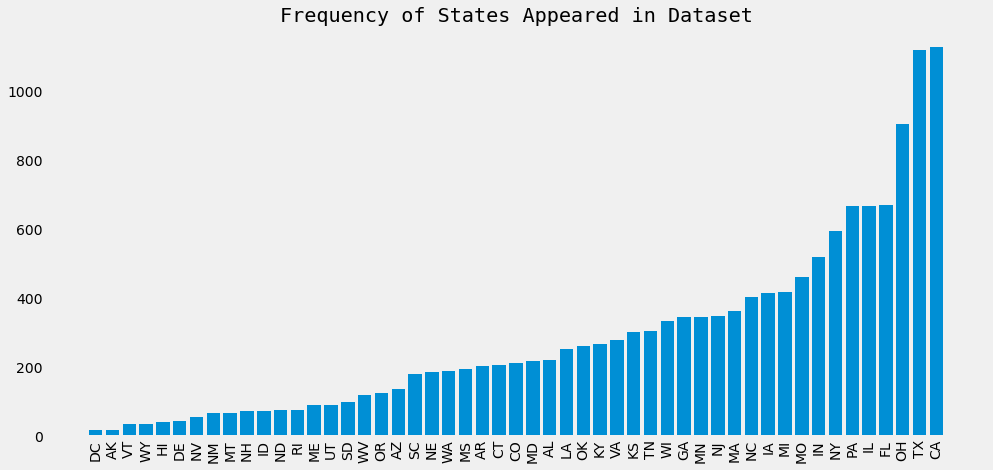

In [13]:
counter = Counter(q['Provider State'])
counter = dict(sorted(counter.items(), key=lambda kv: kv[1]))
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15,7))
plt.bar(counter.keys(),counter.values())
plt.title('Frequency of States Appeared in Dataset', family = 'monospace')
plt.xticks(rotation = 90)
plt.grid(False)
plt.show()

In [14]:
q['Provider Zip Code'] = np.trunc(q['Provider Zip Code']/10000).astype('int')

In [15]:
q=q.select_dtypes(exclude='object')

### Training, Validation, Testing Split <a id = 'split'></a>

In [16]:
# Split test and train, and separate X, Overall Rating y, and Abuse Icon y
X_train, X_test, abu_y_train, abu_y_test = train_test_split(q.drop(['Overall Rating', 'Abuse Icon'],axis =1),
                                                   q['Abuse Icon'],
                                                   test_size=.40, random_state = 111)

X_train1, X_test1, rat_y_train, rat_y_test = train_test_split(q.drop(['Overall Rating', 'Abuse Icon'],axis =1),
                                                   q['Overall Rating'],
                                                   test_size=.40, random_state = 111)

In [17]:
# Split test and valid for Abuse Icon and Overall Rating
X_valid, X_test, abu_y_valid, abu_y_test = train_test_split(X_test,
                                                   abu_y_test,
                                                   test_size=.5, random_state = 111)

X_valid1, X_test1, rat_y_valid, rat_y_test = train_test_split(X_test1,
                                                   rat_y_test,
                                                   test_size=.5, random_state = 111)

In [18]:
print({'training size':len(X_train),
       'testing size':len(X_test),
       'validation size':len(X_valid)})

{'training size': 8678, 'testing size': 2893, 'validation size': 2893}


### Standardize Features <a id = 'standardize'></a>

In [19]:
# Standardize all sets without data leakage
zscore = StandardScaler()
zscore.fit(X_train)

zscore1 = StandardScaler()
zscore1.fit(X_train1)

# Apply it
X_train = pd.DataFrame(zscore.transform(X_train))
X_valid = pd.DataFrame(zscore.transform(X_valid))
X_test = pd.DataFrame(zscore.transform(X_test))

X_train1 = pd.DataFrame(zscore1.transform(X_train1))
X_valid1 = pd.DataFrame(zscore1.transform(X_valid1))
X_test1 = pd.DataFrame(zscore1.transform(X_test1))

# Rename columns
X_train.columns = list(q.drop(['Overall Rating','Abuse Icon'],axis=1).columns)
X_valid.columns = list(q.drop(['Overall Rating','Abuse Icon'],axis=1).columns)
X_test.columns = list(q.drop(['Overall Rating','Abuse Icon'],axis=1).columns) 

X_train1.columns = list(q.drop(['Overall Rating','Abuse Icon'],axis=1).columns)
X_valid1.columns = list(q.drop(['Overall Rating','Abuse Icon'],axis=1).columns)
X_test1.columns = list(q.drop(['Overall Rating','Abuse Icon'],axis=1).columns)

### Feature Selection <a id = 'feature'></a>

In [20]:
lm = LinearRegression()
lm.fit(X_train1,rat_y_train)

LinearRegression()

In [21]:
print('Training R2:',lm.score(X_train1,rat_y_train))
print('Valid R2:',lm.score(X_valid1,rat_y_valid))

Training R2: 0.8570682672389203
Valid R2: 0.8554395761065933


BIC and AIC scores are too high.

In [22]:
# Set the threshold to eliminate high correlation in X
def eliminate_X_corr(X, threshold):
    # Correlate using Pearson
    data = pd.DataFrame(X)
    correlated = pd.DataFrame(data.corr().unstack().sort_values())
    
    # Drop all pair of identical variables being correlated
    correlated.drop(correlated.tail(len(data.select_dtypes(include = ['float',
                    'integer']).columns)).index,inplace=True)
    
    # Limit correlated variables that are higher than threshold or lower than - threshold
    correlated = correlated[(correlated > threshold)]
    correlated = correlated[~correlated[0].isna()].reset_index()
    
    # Drop duplications
    thelist = []
    for i in range(len(correlated)):
        if i % 2 == 0:
            thelist.append(i)
    correlated = correlated.iloc[thelist,:]
    
    # Select list of columns to drop
    thelist = list(correlated.iloc[:,0])
    return data.drop(thelist,axis=1)

In [23]:
sequence = []
i = 0.2
while i <= 1:
    sequence.append(i)
    i += 0.01
    i = round(i,2)

# Create the graph
train = []
valid = []
for i in sequence:
    X = eliminate_X_corr(X_train1,i)
    lm.fit(X,rat_y_train)
    
    X_val = X_valid1[X.columns]
    
    train.append(lm.score(X,rat_y_train))
    valid.append(lm.score(X_val,rat_y_valid))

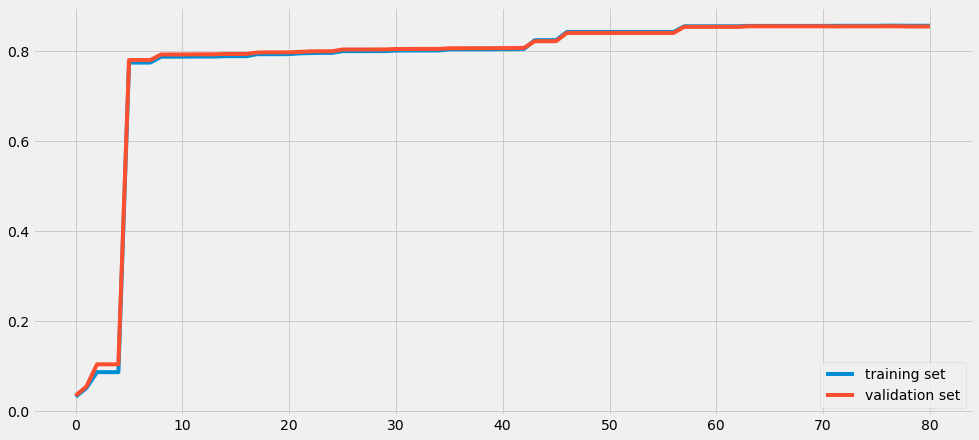

In [24]:
plt.figure(figsize=(15,7))
plt.plot(train,label='training set')
plt.plot(valid,label='validation set')
plt.legend()
plt.show()

In [25]:
log = LogisticRegression()
log.fit(X_train,abu_y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [26]:
print('Training R2:', matthews_corrcoef(abu_y_train, log.predict(X_train)))
print('Valid R2:',matthews_corrcoef(abu_y_valid, log.predict(X_valid)))

Training R2: 0.27356965256746485
Valid R2: 0.26298061239904547


In [27]:
sequence = []
i = 0.2
while i <= 1:
    sequence.append(i)
    i += 0.01
    i = round(i,2)

# Create the graph
train = []
valid = []
for i in sequence:
    X = eliminate_X_corr(X_train,i)
    log.fit(X,abu_y_train)
    
    X_val = X_valid[X.columns]
    
    train.append(matthews_corrcoef(abu_y_train, log.predict(X)))
    valid.append(matthews_corrcoef(abu_y_valid, log.predict(X_val)))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/anaconda3/lib/python3.8/site-packages/sk

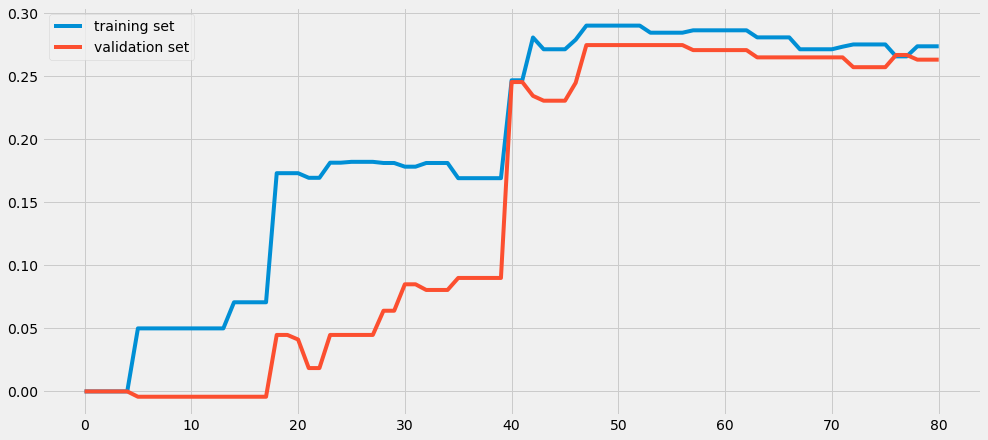

In [28]:
plt.figure(figsize=(15,7))
plt.plot(train,label='training set')
plt.plot(valid,label='validation set')
plt.legend()
plt.show()

In [29]:
sequence = []
i = 0.0
while i <= 1:
    sequence.append(i)
    i += 0.01
    i = round(i,2)

# Create the graph
train = []
valid = []
thei = []
train1 = []
valid1 = []
for i in sequence:
    sel = VarianceThreshold(threshold = i)
    sel.fit(X_train) 
    X = sel.transform(X_train)
    log.fit(X,abu_y_train)
    
    X_val = sel.transform(X_valid)
    
    train.append(matthews_corrcoef(abu_y_train, log.predict(X)))
    valid.append(matthews_corrcoef(abu_y_valid, log.predict(X_val)))

    sel1 = VarianceThreshold(threshold = i)
    sel1.fit(X_train1)
    X1 = sel1.transform(X_train1)
    
    lm.fit(X1,rat_y_train)
    
    X_val1 = sel1.transform(X_valid1)
    
    train1.append(lm.score(X1,rat_y_train))
    valid1.append(lm.score(X_val1,rat_y_valid))
    thei.append(i)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [30]:
scores = pd.DataFrame({'threshold':thei,'classifer_training':train,'regressor_training':train1,
                       'classifer_validation':valid,'regressor_validation':valid1})

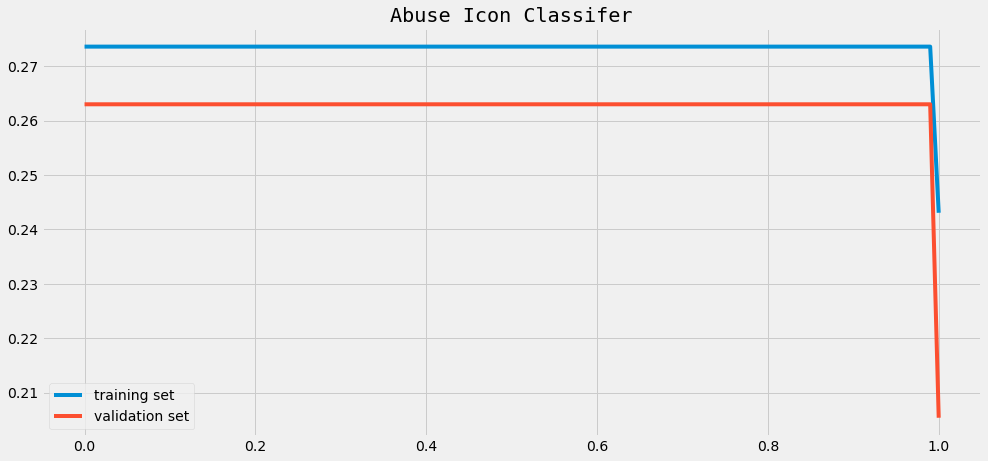

In [31]:
plt.figure(figsize=(15,7))
plt.plot('threshold','classifer_training',data=scores,label='training set')
plt.plot('threshold','classifer_validation',data=scores,label='validation set')
plt.title('Abuse Icon Classifer',family='Monospace')
plt.legend()
plt.show()

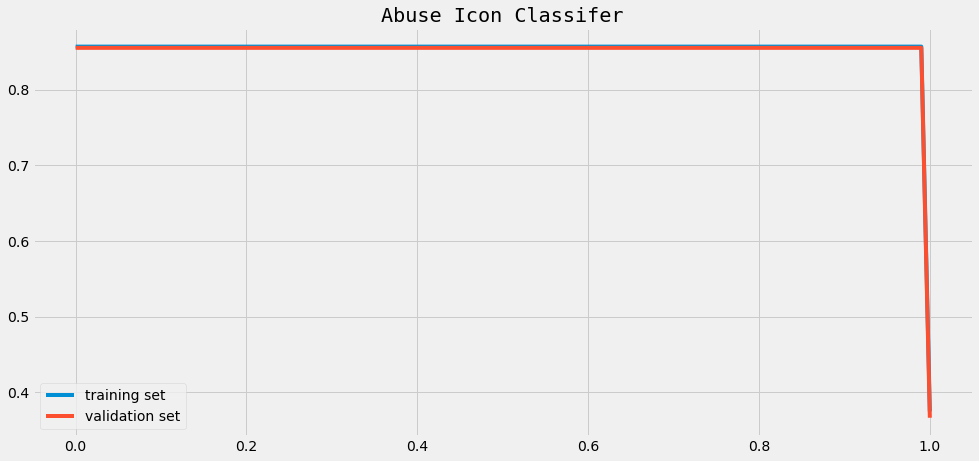

In [32]:
plt.figure(figsize=(15,7))
plt.plot('threshold','regressor_training',data=scores,label='training set')
plt.plot('threshold','regressor_validation',data=scores,label='validation set')
plt.title('Abuse Icon Classifer',family='Monospace')
plt.legend()
plt.show()

### Data Leakage Investigation <a id = 'leakage'></a>

In [33]:
# Remove all ratings and inspection-related inputs other than Health Inspection Rating
eliminate = []
for i in q.columns:
    if ('Rating' in i) and ('Inspection Rating' not in i):
        eliminate.append(i)

eliminate.extend(['Number of Citations from Infection Control Inspections',
                  'Most Recent Health Inspection More Than 2 Years Ago'])
q = q.drop(eliminate,axis=1)

In [34]:
q = q.drop(['Abuse Icon'],axis=1)

In [35]:
q.to_csv('for_prediction')